<a href="https://colab.research.google.com/github/harshilj0310/Data-Science-Notebooks/blob/main/HMM_POS_tagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gradio
import nltk
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from collections import defaultdict
from joblib import Parallel, delayed
import multiprocessing
import time
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gradio as gr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 551.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.0/94.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 8.2 MB/s eta 0:00:00
  Attempting uninstall: tomlkit
    Found existing 

In [ ]:
nltk.download('brown')
nltk.download('universal_tagset')
nltk.download('punkt')
nltk_data = list(nltk.corpus.brown.tagged_sents(tagset='universal'))

# Split into train and test sets (80/20 split)
train_set, test_set = train_test_split(nltk_data, train_size=0.80, test_size=0.20, random_state=101)

# Flatten the train set to extract word-tag pairs
train_tagged_words = [tup for sent in train_set for tup in sent]

# Get the number of available cores for parallelization
num_cores = multiprocessing.cpu_count()

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Step 3: Precompute log probabilities for transition and emission matrices with smoothing
def calculate_frequencies(data):
    transition_counts = defaultdict(int)
    emission_counts = defaultdict(int)
    tag_counts = defaultdict(int)

    for sentence in data:
        previous_tag = '<START>'
        for word, tag in sentence:
            transition_counts[(previous_tag, tag)] += 1
            emission_counts[(tag, word)] += 1
            tag_counts[tag] += 1
            previous_tag = tag

    return transition_counts, emission_counts, tag_counts

transition_counts, emission_counts, tag_counts = calculate_frequencies(nltk_data)

# Get the list of tags and words
tags = sorted(tag_counts.keys())
words = sorted({word for sentence in nltk_data for word, _ in sentence})
words.append('UNK')  # Add 'UNK' for unknown words


In [ ]:
# Function to display the transition matrix
def display_transition_matrix(transition_matrix, tags):
    print("\nTransition Probability Table:")
    df_transition = pd.DataFrame(transition_matrix, index=tags, columns=tags)
    print(df_transition)

# Function to display the emission (lexical) matrix
def display_emission_matrix(emission_matrix, tags, words, sample_size=10):
    print("\nLexical (Emission) Probability Table (sample of words):")
    df_emission = pd.DataFrame(emission_matrix[:, :sample_size], index=tags, columns=words[:sample_size])
    print(df_emission)

In [ ]:
# Step 4: Compute log probability matrices
def create_log_probability_matrices(transition_counts, emission_counts, tag_counts, tags, words, smoothing=1e-8):
    num_tags = len(tags)
    num_words = len(words)

    tag_to_id = {tag: idx for idx, tag in enumerate(tags)}
    word_to_id = {word: idx for idx, word in enumerate(words)}

    transition_matrix = np.zeros((num_tags, num_tags))
    emission_matrix = np.zeros((num_tags, num_words))

    for prev_tag in tags:
        prev_tag_id = tag_to_id[prev_tag]
        total_transitions = sum(
            transition_counts.get((prev_tag, next_tag), 0) for next_tag in tags
        ) + smoothing * num_tags

        for next_tag in tags:
            next_tag_id = tag_to_id[next_tag]
            count = transition_counts.get((prev_tag, next_tag), 0) + smoothing
            transition_matrix[prev_tag_id, next_tag_id] = np.log(count / total_transitions)

    for tag in tags:
        tag_id = tag_to_id[tag]
        total_emissions = tag_counts[tag] + smoothing * num_words

        for word in words:
            word_id = word_to_id[word]
            count = emission_counts.get((tag, word), 0) + smoothing
            emission_matrix[tag_id, word_id] = np.log(count / total_emissions)

    return transition_matrix, emission_matrix, tag_to_id, word_to_id

# Now, print the transition and emission matrices after cross-validation
log_transition_matrix, log_emission_matrix, tag_to_idx, word_to_idx = create_log_probability_matrices(
    transition_counts, emission_counts, tag_counts, tags, words)

display_transition_matrix(log_transition_matrix, tags)


display_emission_matrix(log_emission_matrix, tags, words)



Transition Probability Table:
             .       ADJ       ADP       ADV      CONJ       DET      NOUN  \
.    -1.754715 -3.065917 -2.251057 -2.654602 -2.189217 -2.212535 -2.011856   
ADJ  -2.298412 -2.865822 -2.424694 -4.637841 -3.280670 -5.142512 -0.426262   
ADP  -4.630765 -2.493412 -3.896994 -4.166803 -6.273347 -0.786015 -1.352992   
ADV  -1.770622 -1.992460 -1.952442 -2.334373 -4.055599 -2.609526 -3.416234   
CONJ -3.872171 -2.189417 -2.613310 -2.393318 -8.246670 -1.888481 -1.412131   
DET  -4.359801 -1.428158 -4.702460 -4.044519 -7.350407 -5.131945 -0.467526   
NOUN -1.256449 -4.347683 -1.405944 -3.631444 -2.815333 -4.163862 -1.898398   
NUM  -1.301200 -2.819785 -2.026392 -3.888244 -3.256341 -4.328977 -0.960974   
PRON -2.266139 -4.657799 -2.885821 -2.918308 -4.474766 -4.044695 -4.726334   
PRT  -2.567501 -3.967880 -2.399708 -3.319145 -4.405781 -2.482094 -3.331266   
VERB -2.517471 -2.855234 -1.775996 -2.270571 -4.241338 -1.813589 -2.327295   
X    -1.292562 -5.846439 -2.92866

In [ ]:
# Step 5: Optimized Viterbi Algorithm using log probabilities
def Viterbi_optimized_log_probabilities(words, log_transition_matrix, tag_to_idx, tags, log_emission_matrix, word_to_idx):
    T = list(tags)
    prob = np.zeros((len(T), len(words)))
    backpointer = np.zeros((len(T), len(words)), dtype=int)


    for i, tag in enumerate(T):
        prob[i, 0] = log_emission_matrix[i, word_to_idx.get(words[0], word_to_idx['UNK'])]


    for t in range(1, len(words)):
        for i, tag_i in enumerate(T):
            max_tr_prob = max(prob[j, t-1] + log_transition_matrix[j, i] for j in range(len(T)))
            prob[i, t] = max_tr_prob + log_emission_matrix[i, word_to_idx.get(words[t], word_to_idx['UNK'])]
            backpointer[i, t] = np.argmax([prob[j, t-1] + log_transition_matrix[j, i] for j in range(len(T))])


    best_path = [np.argmax(prob[:, -1])]
    for t in range(len(words) - 1, 0, -1):
        best_tag = backpointer[best_path[-1], t]
        best_path.append(best_tag)

    best_path = best_path[::-1]
    state = [T[idx] for idx in best_path]

    return list(zip(words, state))


In [ ]:
# Step 6: Parallelize Cross-Validation using joblib
def run_viterbi_for_sentence(test_sentence, log_transition_matrix, tag_to_idx, tags, log_emission_matrix, word_to_idx):
    return Viterbi_optimized_log_probabilities(test_sentence, log_transition_matrix, tag_to_idx, tags, log_emission_matrix, word_to_idx)

def cross_validate_in_parallel_sentences(train_set, test_set, n_splits=5):
    kf = KFold(n_splits=n_splits)

    # Precompute frequencies and log probabilities
    transition_counts, emission_counts, tag_counts = calculate_frequencies(train_set)
    tags = sorted(tag_counts.keys())
    words = sorted({word for sentence in train_set for word, _ in sentence})
    words.append('UNK')  # Handle unknown words

    # Create log transition and emission matrices
    log_transition_matrix, log_emission_matrix, tag_to_idx, word_to_idx = create_log_probability_matrices(
        transition_counts, emission_counts, tag_counts, tags, words)

    all_true_tags = []
    all_pred_tags = []
    fold_accuracies = []

    # Use Parallel from joblib to run cross-validation in parallel
    for train_index, test_index in kf.split(test_set):
        # Extract test sentences for this fold
        test_fold = [test_set[i] for i in test_index]
        test_sentences = [[word for word, _ in sent] for sent in test_fold]  # Get word sequences

        # Parallel processing of Viterbi on multiple test sentences
        fold_results = Parallel(n_jobs=num_cores)(
            delayed(run_viterbi_for_sentence)(sentence, log_transition_matrix, tag_to_idx, tags, log_emission_matrix, word_to_idx)
            for sentence in test_sentences
        )

        # Flatten true and predicted tags for confusion matrix and per POS accuracy
        true_tags = [tag for sent in test_fold for _, tag in sent]
        pred_tags = [tag for sent in fold_results for _, tag in sent]

        all_true_tags.extend(true_tags)
        all_pred_tags.extend(pred_tags)

        # Calculate accuracy for this fold
        accuracy = calculate_accuracy(test_fold, fold_results)
        fold_accuracies.append(accuracy)
        print(f"Fold accuracy: {accuracy:.4f}")

    return all_true_tags, all_pred_tags, fold_accuracies


def calculate_accuracy(true_sentences, predicted_sentences):
    total_words = 0
    correct_tags = 0

    for true_sent, pred_sent in zip(true_sentences, predicted_sentences):
        for (true_word, true_tag), (_, pred_tag) in zip(true_sent, pred_sent):
            total_words += 1
            if true_tag == pred_tag:
                correct_tags += 1

    accuracy = correct_tags / total_words if total_words > 0 else 0
    return accuracy

In [ ]:
# Step 6: Gradio Interface for POS Tagging
def pos_tag_sentence(sentence):
    # Ensure 'punkt' is downloaded for tokenization
    nltk.download('punkt')
    try:
        words = nltk.word_tokenize(sentence.lower())
        predicted_tags = Viterbi_optimized_log_probabilities(words, log_transition_matrix, tag_to_idx, tags, log_emission_matrix, word_to_idx)
        formatted_output = ' '.join([f"{word}_{tag}" for word, tag in predicted_tags])
        return formatted_output
    except Exception as e:
        return f"Error: {str(e)}"

# Gradio Interface Setup
interface = gr.Interface(fn=pos_tag_sentence,
                         inputs="text",
                         outputs="text",
                         title="POS Tagger",
                         description="Enter a sentence, and the model will return the POS tags.")

# Launch the Gradio interface
interface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://ad3540d4a11d213d18.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
# Step 8: Measure Execution Time, Cross-Validation Accuracy, and Confusion Matrix
start_time = time.time()

# Run cross-validation in parallel (5-fold)
all_true_tags, all_pred_tags, fold_accuracies = cross_validate_in_parallel_sentences(train_set, test_set, n_splits=5)

end_time = time.time()
execution_time = end_time - start_time

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_true_tags, all_pred_tags, labels=sorted(set(all_true_tags)))

# Print total execution time, overall accuracy, and confusion matrix
print(f"Total cross-validation time: {execution_time:.2f} seconds")
print(f"Average accuracy across folds: {np.mean(fold_accuracies):.4f}")

# Print per POS accuracy
print("\nPer POS tag classification report:")
print(classification_report(all_true_tags, all_pred_tags, labels=sorted(set(all_true_tags))))


Fold accuracy: 0.9515
Fold accuracy: 0.9554
Fold accuracy: 0.9534
Fold accuracy: 0.9536
Fold accuracy: 0.9549
Total cross-validation time: 127.17 seconds
Average accuracy across folds: 0.9538

Per POS tag classification report:
              precision    recall  f1-score   support

           .       0.98      1.00      0.99     29701
         ADJ       0.92      0.91      0.92     16852
         ADP       0.96      0.97      0.96     29177
         ADV       0.88      0.90      0.89     11383
        CONJ       0.96      0.99      0.98      7655
         DET       0.98      0.99      0.98     27692
        NOUN       0.97      0.93      0.95     55378
         NUM       0.84      0.92      0.88      2838
        PRON       0.96      0.98      0.97     10032
         PRT       0.88      0.91      0.89      6074
        VERB       0.98      0.95      0.96     37018
           X       0.13      0.75      0.22       300

    accuracy                           0.95    234100
   macro avg  

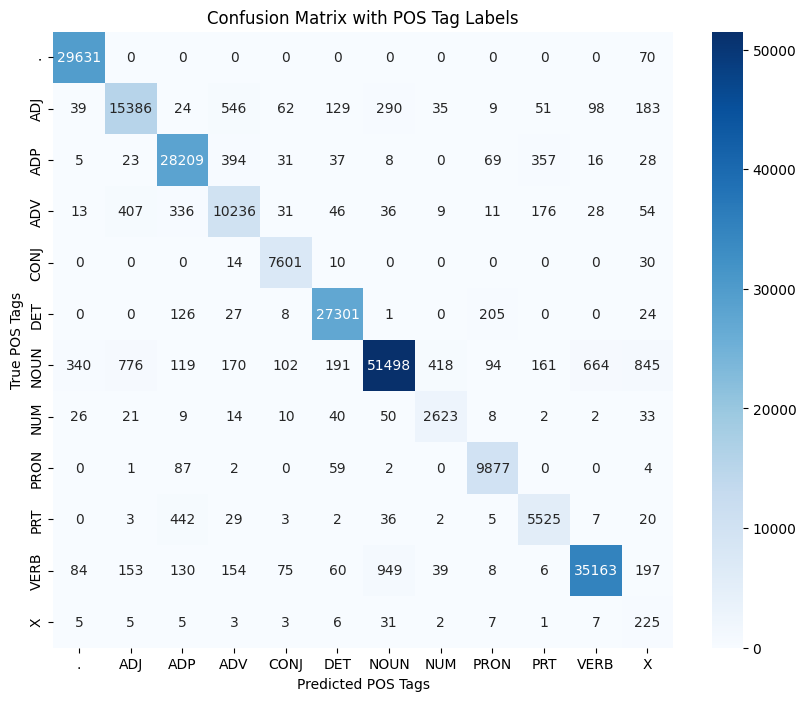

In [ ]:

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=tags, yticklabels=tags)

plt.xlabel('Predicted POS Tags')
plt.ylabel('True POS Tags')
plt.title('Confusion Matrix with POS Tag Labels')
plt.show()